(ch2:getdata)=
# Get the Data

For this section, you will start to get your hands dirty with some real network datasets. Don't be afraid to walk through these examples with your laptop in a jupyter notebook. To ease your ability to interact directly with the code of this book, we've developed a standalone `docker` container that you can use. 

## Interacting with the book via docker

Getting software to run across multiple operating systems, particularly software with lots of dependencies, can range from difficult to impossible. While most of the packages required to run the contents of this book can be installed relatively easily via a combination of git, pip, and virtual environments, the easiest and fastest way to get you coding and interacting with real python code is docker. 

Docker is a containerization utility that, in effect, allows you to run standalone software in a separate area of your computer (called a *docker container*), that allows software to operate without conflicting with your local operating system. This means that you can, with a very small number of button clicks, create deployable software that thousands of people can use at the drop of a hat. It might not be better than sliced bread, but it might be the next best thing! 

We aren't going to sit here and pretend to be the experts on docker, but fortunately the people over at docker won't leave you on your own for that one! To install docker, check out their installation guide at {cite:p}`dockerinstall`. 

### Obtaining the docker container for the textbook

Once you have docker installed on your computer, you can obtain the docker container for the book relatively easily. If you have a ubuntu/mac operating system and the docker daemon running on your computer, you can open up a terminal session and type the following command:

```
$ docker pull neurodata/graph-stats-book
```

which will fetch the docker container for the book from {cite:p}`thisbookdocker`.

This docker container contains all of the dependencies needed to run the code within this book, and will allow you to use the book in conjunction with jupyter. Jupyter is a lightweight, web-based interactive computing platform that you can access through your web browser at `localhost:<port>`, where `<port>` is the port you provide to the container for execution. You can start the docker container like this:

```
$ docker run -it --rm -p <port>:8888 neurodata/graph-stats-book jupyter-lab --ip=0.0.0.0 --port=8888 /home/book/ --NotebookApp.token="graphbook"
```

Which will launch a `jupyter-lab` session, and *should* automatically log you into the session in your browser. If it does not, open up a browser of your choice, and go to `localhost:<port>`, where you will be prompted to enter the log-in password for your session. If you don't know what port to choose, it's probably easiest to try `8888`, and if that doesn't work, `8889`, and keep working up until you find an open port. The port is so that your browser can communicate with the jupyter session inside the docker container (which runs jupyter internally on port `8888`), and so you are basically telling your computer that your port `<port>` should "tie in" to port `8888` in the docker container. The password for the session is `graphbook`, or any password you choose to enter.

If you don't want to use the docker container, that's fine too: you can follow the instructions at the bottom of the page for [installing graspologic locally](ch2:get:install) for more details. 

## Downloading the data

When you work with network data, it is rarely the case that the *raw data* that you will use is already a network. The **raw data** is the least processed version of the data for your project, and is the information upon which the rest of your data is *derived*. A **derivative** is a piece of data or information that is *derived* from the raw data. Consider, for instance, that you are investigating emailing trends for a company, and trying to see whether employees tend to email their team members more or less frequently than people outside of their team. In this case, your raw data might be a list of emails, coupled with the sender, and the recipient, of each email. You might be responsible for *preprocessing* this data to acquire a network derivative for your later analyses.

In this section, you won't worry just yet about preprocessing a raw dataset, and will instead start with some pre-prepared data. You will be working with brain networks from a human functional MRI connectome. You could navigate over to the `neurodata` website and download the file directly, but it tends to be useful to get used to how to do this programmatically. This is because if the data changes, you might want your analysis to automatically update and pertain to the latest and best version of the data at the time you execute your function. Further, if you intend your code to be reproducible, having a function which downloads and prepares the data in a way in which the computer can use greatly will simplify the process of disseminating your work. 

To begin, we'll start with a code snippet which fetches the required data for our analysis:

In [10]:
import os
import urllib
import boto3
from botocore import UNSIGNED
from botocore.client import Config
from graspologic.utils import import_edgelist
import numpy as np
import glob

# the AWS bucket the data is stored in
BUCKET_ROOT = "open-neurodata"
parcellation = "Schaefer400"
FMRI_PREFIX = "m2g/Functional/BNU1-11-12-20-m2g-func/Connectomes/" + parcellation + "_space-MNI152NLin6_res-2x2x2.nii.gz/"
FMRI_PATH = os.path.join("datasets", "fmri")  # the output folder
DS_KEY = "abs_edgelist"  # correlation matrices for the networks to exclude

def fetch_fmri_data(bucket=BUCKET_ROOT, fmri_prefix=FMRI_PREFIX,
                    output=FMRI_PATH, name=DS_KEY):
    """
    A function to fetch fMRI connectomes from AWS S3.
    """
    # check that output directory exists
    if not os.path.isdir(FMRI_PATH):
        os.makedirs(FMRI_PATH)
    # start boto3 session anonymously
    s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))
    # obtain the filenames
    bucket_conts = s3.list_objects(Bucket=bucket, 
                    Prefix=fmri_prefix)["Contents"]
    for s3_key in bucket_conts:
        # get the filename
        s3_object = s3_key['Key']
        # verify that we are grabbing the right file
        if name not in s3_object:
            op_fname = os.path.join(FMRI_PATH, str(s3_object.split('/')[-1]))
            if not os.path.exists(op_fname):
                s3.download_file(bucket, s3_object, op_fname)

def read_fmri_data(path=FMRI_PATH):
    """
    A function which loads the connectomes as adjacency matrices.
    """
    # import edgelists with graspologic
    # edgelists will be all of the files that end in a csv
    networks = [import_edgelist(fname) for fname in glob.glob(os.path.join(path, "*.csv"))]
    return np.stack(networks, axis=0)

Now when you call `fetch_dwi_data()`, it creates a new directory called `datasets/fmri` in your workspace, and downloads the adjacency matrices, the standard way to represent a graph as a mathematical object, into your local directory `datasets/fmri`.

Next, we'll try to load the dataset using the `graspologic` utility, `import_edgelist()`:

In [11]:
fetch_fmri_data()
As = read_fmri_data()

Next, let's learn some things about just one of the adjacency matrices. In network machine learning, when dealing with a new dataset, our recommendation is to *always*, *always*, start with visualization. You typically visualize network data using a heatmap:

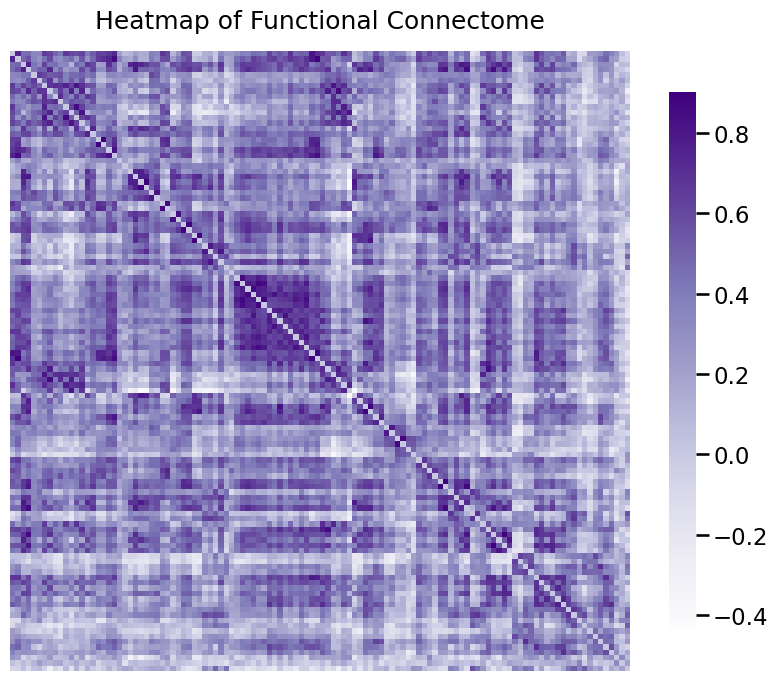

In [12]:
from graphbook_code import heatmap

A = As[0]
ax = heatmap(A, title="Heatmap of Functional Connectome")

What this has done is it has plotted the adjacency matrix for the functional connectome of a human. A heatmap is a network visualization in which the $x$ and $y$ coordinates of a given entry in the matrix indicate the pair of nodes an edge is connected to, and the color for the $(x,y)$ point in the figure indicates the weight of the edge between nodes $x$ and $y$. The edge weight is stronger if the pair of voxels have more connections, and smaller if the pair of voxels have weaker connections. 

One thing that we can notice from this plot is that a lot of these edges have really small weights! Let's explore this a little bit further. 

A useful summary of the network is to look at a histogram for the edge-weights. A histogram shows the number of edges (on the vertical axis) which have a given edge weight range (indicated by the width of a particular bar on the horizontal axis). You can call this directly on the adjacency matrix (albeit flattened), and it will plot a histogram of the edge weights. You will do this using seaborn's `histplot()`:

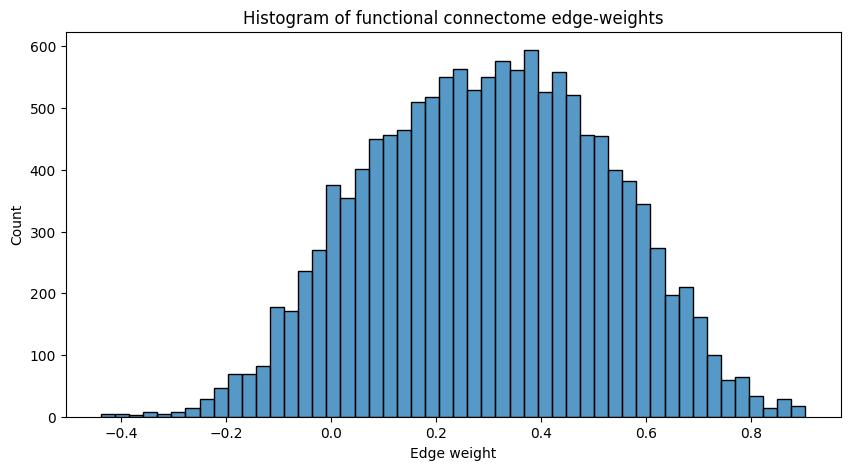

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1, figsize=(10, 5))
sns.histplot(A.flatten(), ax=ax, bins=50);
ax.set_xlabel("Edge weight")
ax.set_title("Histogram of functional connectome edge-weights");

A lot of the edge-weights tend to be right around the $0.1$ to $0.5$ range, which tells us that, in general, the nodes of the network are *slightly correlated*. This means that, in general, when some node tends to be active, other nodes also tend to be active. If this were not the case, the histogram would be a bit more centered around $0.0$.

(ch2:get:install)=
## Create the workspace

### Installing the latest version of python

To begin, you will need a suitable instance of python installed. For this book, you used python 3.8, but the most advanced version of python 3 at the time you are reading should do the trick. You will assume that you are using a Linux or UNIX-like operating system, such as OSX. If you have a Windows computer, you would recommend that you use the Linux subsystem module, which you can find more details about in {cite:p}`windowsss` to interact with the codebase. Once you have this set up and up and running, you can follow the instructions below for a Debian distribution of Linux.

Once you have your computer handy, you can run the following command, which should show (ideally) `python3` has a version $\geq$`3.8.0`:

```
$ python3 -V
Python 3.8.0
```

and verify that the python package manager, `pip`, is installed:

```
$ python3 -m pip --version
pip 22.0.3 from /home/<user>/.virtualenvs/graph-book/lib/python3.8/site-packages/pip (python 3.8)
```

This command will print the version of `python3` and `pip` that your computer currently has installed. If it returns any version below `3.8.x` or says "command not found", you will need to obtain and install python 3 (along with the developer libraries and the package manager, `pip`) before continuing. The developer libraries are critical to ensuring that code upon which packages in python are based (such as the popular `numpy` numerical package) have the appropriate libraries needed to execute code written in *other* programming languages, which might be faster (for instance, `C`). 

If you have an apple computer using the OSX operating system, you can download and install an appropriate version of python using the python 3 guide for OSX at {cite:p}`pythonmac` by first configuring `homebrew` and then installing python. This will also include `pip`. 

If you are using a Debian-based Linux distribution (such as Ubuntu), you can install python 3 along with the developer libraries and `pip` by typing:

```
$ sudo apt-get update
$ sudo apt-get install -y python3-dev python3-pip
```

If you have a CentOS distribution (such as CentOS or Red Hat), you can install python3 along with the developer libraries and `pip` by typing:

```
$ sudo yum update
$ sudo yum install -y python3-devel python3-pip
```

You should make sure that you have the most recent version of `pip` installed. To upgrade the current `pip` package, type:

```
$ python3 -m pip install --user -U pip
Collecting pip
[...]
Successfully installed pip-22.0.3
```

You now have `python3`, the python package manager `pip`, and the `python3` developer libraries installed on your computer. 

### Installing fortran

Some of the packages that you will use in the book require the system to have an appropriate version of a programming language called FORTRAN installed. FORTRAN is a numerical programming language which is very fast for mathematical computations. Fortran is included in the package `gcc`, which is a collection of compilers for many programming languages.

If you have a MAC system, you can install `gfortran` with the following command:

```
$ sudo brew install gcc
```

If you have a Debian system, you can install `gfortran` with the following command:

```
$ sudo apt-get update
$ sudo apt-get install gcc
```

If you have a CentOS system, you can install `gfortran` with the following command:

```
$ sudo yum update
$ sudo yum install gcc
```

### Establishing a virtual environment

It is often good practice in python to avoid installing many packages directly to `python3` itself. This is because packages in python do not necessarily have the same dependencies, and particular projects might require package versions that conflict with other projects you are working on. For instance, I might have a homework assignment that works only with numpy version 1.18.1, but meanwhile, a work project needs numpy version 1.22.0. For this reason, you strongly encourage you to use virtual environments.

To begin working with virtual environments in python, you will need to first obtain the `virtualenv` python package:

```
$ pip3 install virtualenv
Collecting package virtualenv
[...]
Successfully installed virtualenv-20.13.1
```

Once you have `virtualenv` installed, you can create your first virtual environment in python. You will first make a directory in your home directory which will allow us to keep track of your virtual environments, and then you will make a new virtual environment for the book which uses `python3`:

```
$ # create a new directory for virtual environments
$ mkdir ~/.virtualenvs
$ # make a new virtual environment using python3
$ virtualenv -p python3 ~/.virtualenvs/graph-book
```

Every time you want to use run code for the book, you should first use the following command to activate the virtual environment:

```
$ # activate the virtual env
$ source ~/.virtualenv/bin/activate
(graph-book) $ 
```

You should run this command before continuing to the next section.

### Installing the dependencies for the book

Next, you need to install the python package dependencies for the book. Once you have your virtual environment activated, you will next want to grab the requirements file for the graph book, which can be obtained by typing:


```
(graph-book) $ wget https://raw.githubusercontent.com/neurodata/graph-stats-book/master/requirements.txt
```

Next, you will want to install the appropriate python packages specified in the `requirements.txt` file, by typing:

```
(graph-book) $ pip install -r requirements.txt
```

Since you are in a virtual environment, you no longer have to worry about making sure you are installing these to `python3` or `pip3`, since the virtual environment streamlines all of these function calls for us directly. Finally, you will need to install `jupyter-lab` and the ipython kernel, using the following commands:


```
(graph-book) $ pip install jupyterlab ipykernel
```

We need to add your virtual environment to the ipython kernel so that jupyter lab can find it, which you can do by typing:


```
(graph-book) $ python -m ipykernel install --user --name=graph-book
Installed kernelspec myenv in /home/<user>/.local/share/jupyter/kernels/graph-book
```

This will ensure that packages you install to the `graph-book` virtual environment will be findable from within jupyter.

### Setting up jupyter notebook

Now that you have all your packages installed, you can finally move to starting up a notebook. Let's begin by first launching jupyter lab:

```
(graph-book) $ jupyter-lab

```

Next, you want to create a new notebook using the `graph-book` module, as shown in Figure {numref}`graphbook-mod`:

```{figure} ../../Images/jupyter.png
---
scale: 80%
align: center
name: graphbook-mod
---
Select the graph-book kernel, indicated by the red box.
```

To verify that your notebook has the proper software installed, you will make a code cell which simply imports the `graspologic` package, by typing the following command in the top cell:

```
import graspologic
graspologic.__version__
```

and then pressing the `Shift + Enter` keys simultaneously. Note that this cell will take a few seconds to execute successfully. In your notebook, this will look like {numref}`graphbook-grasp`:


```{figure} ../../Images/jupyter_grasp.png
---
scale: 80%
align: center
name: graphbook-grasp
---
Make sure that graspologic package imports, by verifying that it can print its version successfully.
```

From this point forward, for each section of the book, you should be able to copy and paste code snippets section by section, and successfully reproduce the executable code contained within the book. You should take care to make sure that if you take this approach that you make sure to copy and paste all code that appears in the section, since there may be modules which are imported in above cells that are assumed to have been imported in later cells.

## References

```{bibliography}
:filter: docname in docnames
:style: unsrt
```